# Pychrom - A Python Library for Simulation and Optimization of HPLC

Pychrom is a Python library that I'm developing for the simulation and optimization of 1D and 2D [high performance liquid chromatography](https://en.wikipedia.org/wiki/High-performance_liquid_chromatography). This notebook shows some basic functionalities that are included in the current version of the library. I've started developing Pychrom for rapid prototyping of new algorithms for automatic HPLC optimization, as part of the research project [NEXTCHROM](https://citius.usc.es/r/197), in collaboration with the Analytical Chemistry Institute of the University of Santiago de Compostela and [MestreLab Research](http://mestrelab.com).

Unfortunately, and due to restrictions of the project, Pychrom is not open-source. If you are interested in software tools  for end-users, please contact MestreLab for more information.

![2D HPLC conceptual representation by Agilent](img/2dlc-schema.png)

In [10]:
import sys
sys.path.insert(0, '../src/')

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pychrom as pyc


if ('ggplot' in plt.style.available):
    plt.style.use('ggplot')

%matplotlib inline

## Functions

Pychrom includes some classes to define and compose functions. These functions can be used to generate complex gradient programs. This is useful to simulate the concentrations of the solvent that is mixed by different HPLC controllers.

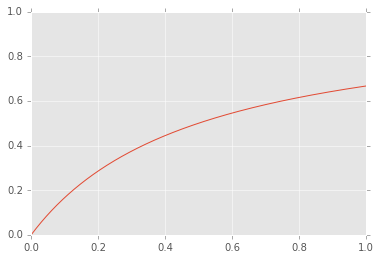

In [11]:
from pychrom.models.functions import Function, GradientFunction, GradientProfile, identity, ramp, const

fun1 = Function(lambda x: (x / (x + 0.5)))
fun1.plot()

Functions can be composed to create complex gradients. For example, we can define a complex 2DLC gradient profile by simulating the 2D valve switch.

$$ f_{2D}(x) = min(f_1(x), f_2(x)) + f_m(x) \times \mid f_1(x) - f_2(x) \mid$$


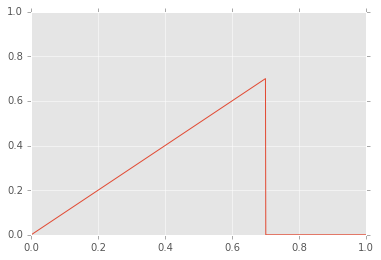

In [12]:
def profile2D(x):
    if x < 0.7:
        return x
    else:
        return 0.
    
prof2df = Function(np.vectorize(profile2D))
prof2df.plot()

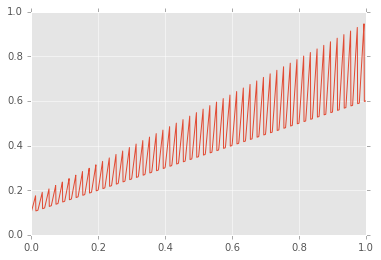

In [86]:
f1 = Function(lambda x: 0.2 + 0.9*x)
f2 = Function(lambda x: 0.1 + 0.5*x)
f2d = f1.min(f2).add(prof2df.rep(50).mul(f1.diff(f2).abs())).clip()
f2d.plot()

## Gradient Profiles

Gradient profiles are a set of functions that are used by the simulator to determine the values of different parameters of the system for each time instant (such as % strongest solvent, temperature of the column, pH...) during the elution process

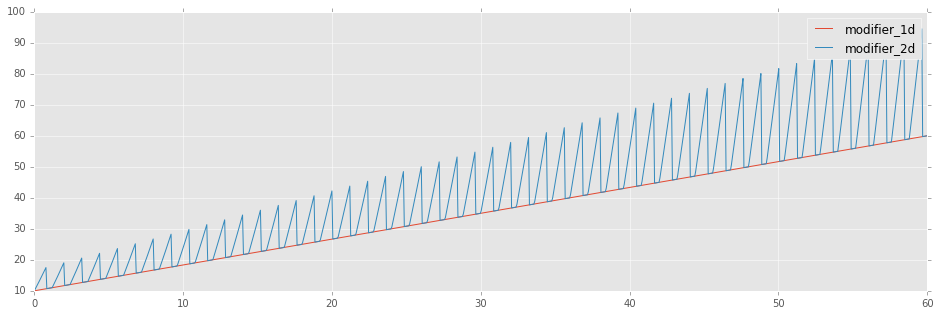

In [14]:
profile = GradientProfile([f2, f2d],  
                       [[0, 100], [0, 100]],
                       ['modifier_1d', 'modifier_2d'], 60)

fig, ax = plt.subplots(figsize=(16, 5))
profile.plot(ax=ax, legend=True)

In [96]:
# A gradient profile is also a multivalued function that returns the value for each gradient function at the
# given instant
profile(10)

{'modifier_1d': 18.333333333333336, 'modifier_2d': 23.888888888888872}

## Loading datasets for 1DLC and 2DLC

Datasets for each column/controller can be loaded from xls files. Each dataset contains a set of gradient experiments that are used to build a model for each peak based on the Linear Strength Solvent (LSS) theory.

In [16]:
# Load 2DLC sample datasets
dataset1d = pyc.datasets.load_peak_tracking_dataset('datasets/exp33_hypercarb_2DLC_1D.xls')
dataset2d = pyc.datasets.load_peak_tracking_dataset('datasets/exp33_trinity_2DLC_2D.xls')

# 1D Config
column1d = pyc.COLUMN_HYPERCARB
controller1d = pyc.CONTROLLER_AGILENT_1290_INFII

# 2D Config
column2d = pyc.COLUMN_TRINITY_P1
controller2d = pyc.CONTROLLER_WATERS_ALLIANCE_2695

In [62]:
dataset1d.predictors

['temperature']

In [63]:
dataset2d.predictors

['buffer_concentration']

## Simulation of 1D Liquid Chromatography (1DLC)

In [98]:
from pychrom.simulators.hplc import HPLCSim

# Create a HPLC simulator and load the dataset. The HPLCSim automatically builds the retention models
# of each peak based on the provided experimental data
hplcsim1d = HPLCSim(column1d, controller1d)
hplcsim1d.load(dataset1d)

In [19]:
# Retention models can be accessed via regmodels dict
hplcsim1d.regmodels

{'246THB': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110d68>,
 '24DHB': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110e10>,
 '24DMB': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110780>,
 '24DMBA': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf43cdd908>,
 '345TMBA': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110cc0>,
 '345TMC': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf210fcfd0>,
 '35DHB': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110c18>,
 '35DMBA': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110ac8>,
 '3OHBA': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf211108d0>,
 '4OHBA': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf210e7c50>,
 'm-cumarico': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110b70>,
 'o-cumaric': <pychrom.learning.models.LSSPeakRetentionModel at 0x7fdf21110eb8>,
 'o-vanillina': <pychrom.learning.models.LSSPeakRetentionMode

In [66]:
# Predict the parameters of the LSS model of the analyte '24DHB' for a temperature of 80ºC
hplcsim1d.regmodels['24DHB'].predict({'temperature': 80})

LSS(logkw=1.9291770988892647, S=3.323267800478334)

<Container object of 3 artists>

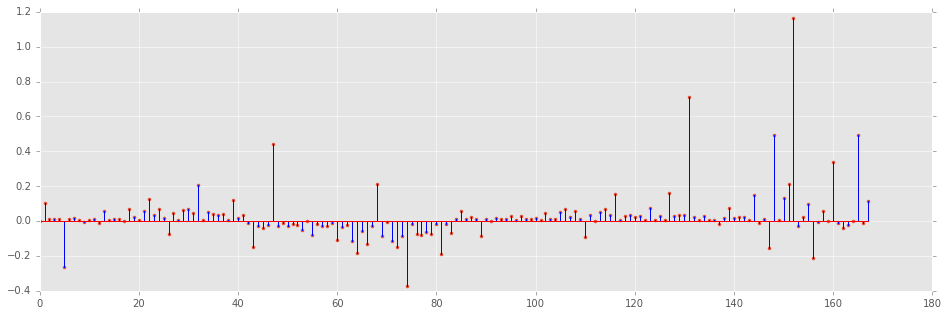

In [87]:
# Show the residuals of the model (both training and test)
from pychrom.learning.validation import model_errors
errors1d = model_errors(dataset1d, hplcsim1d, steps=1000)
plt.figure(figsize=(16, 5))
plt.stem(errors1d, markerfmt='.')

In [88]:
rd1 = hplcsim1d.simulate(60, [0.05, 0.95], programs=dict(temperature=85), flowrate=0.5)
rd1

{'246THB': (3.5775709410028607, 0.39208983899174749),
 '24DHB': (12.010327774449351, 0.59788772745097563),
 '24DMB': (17.823559543963821, 1.0698571810529274),
 '24DMBA': (22.103185349280871, 0.9989882418253474),
 '345TMBA': (19.486835078655243, 0.96657962407369225),
 '345TMC': (32.073149826643082, 1.3942416899803831),
 '35DHB': (17.403226885653172, 0.29553533982362146),
 '35DMBA': (24.755099420452378, 0.97185325302451542),
 '3OHBA': (4.4102541539669531, 0.4099137399988606),
 '4OHBA': (5.2762452366178989, 0.49261413971646223),
 'm-cumarico': (17.179269176971367, 0.97885643483397833),
 'o-cumaric': (17.946600381187842, 1.0607712764905028),
 'o-vanillina': (14.021658427953328, 0.93789483020692188),
 'p-anisaldehido': (12.849377130107369, 0.78276234573031656),
 'p-coumaric': (16.97849061780526, 0.95325156882443951),
 'scopoletine': (28.977526926927933, 1.6334380850657473),
 'sinapic': (32.878233778834719, 1.8111515909831315),
 'syringaldehyde': (18.330825814598811, 0.94120964273772523),
 '

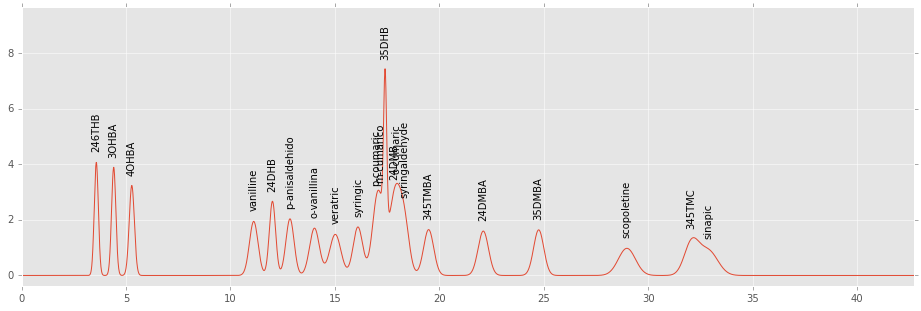

In [99]:
from pychrom.tools.plotting import plot_chrom
plot_chrom(rd1, figsize=(16, 5))

## 1DLC Optimization

In [100]:
# TODO

## 2DLC Simulation

In [101]:
# TODO